In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk

### Data Cleaning

Our dataset is a collection of 18,000 newsgroup documents from 20 different newgroups. The dataset has been split into training and testing subsets. We will be training our topic model on the larger subset, the training set. Since our algorithm is an unsupervised machine learning algorithm, we will not be using the test set. Additionally, the target values for the 20 different newsgroups will be used to assess the evaluation of our model in correctly extracting relevant topics.

In [25]:
# import dataset from sklearn and remove headers and footers for a more realistic model

from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(subset='train', remove=['headers', 'footers'])

Past research on this dataset has shown a tendency for topic models to overfit on headers, so we have removed them from the data. This will improve generalizability to other documents that do not follow the same format.

The data is split into document contents and targets. The 20 newsgroup targets are show below.

In [26]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

An example of a document and its corresponding newsgroup is illustrated. _Data_ includes the content of the newsgroup document, _target_ includes the index of the category of the newsgroup, and _target_names_ includes the name of the category of the newsgroup.

In [27]:
dataset.data[3]

"Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:\n> > Anyone know about the Weitek P9000 graphics chip?\n> As far as the low-level stuff goes, it looks pretty nice.  It's got this\n> quadrilateral fill command that requires just the four points.\n\nDo you have Weitek's address/phone number?  I'd like to get some information\nabout this chip.\n"

In [28]:
dataset.target[3], dataset.target_names[dataset.target[3]]

(1, 'comp.graphics')

We can represent this data as a dataframe for more efficient data cleaning and data exploration.

In [29]:
newsgroup_df = pd.DataFrame({"document": dataset.data, "target": dataset.target})
newsgroup_df = newsgroup_df.assign(newsgroup=newsgroup_df["target"].apply(lambda x: dataset.target_names[x]))
newsgroup_df.head()

,document,target,newsgroup
0,I was wondering if anyone out there could enli...,7,rec.autos
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the gh...",4,comp.sys.mac.hardware
3,Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> a...,1,comp.graphics
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space


Let's do some exploratory data analysis to better understand our dataset. First, we can look at the distriubtion of our newsgroup targets to see if there are any outliers.

Text(0.5, 0, 'Number of Corresponding Documents')

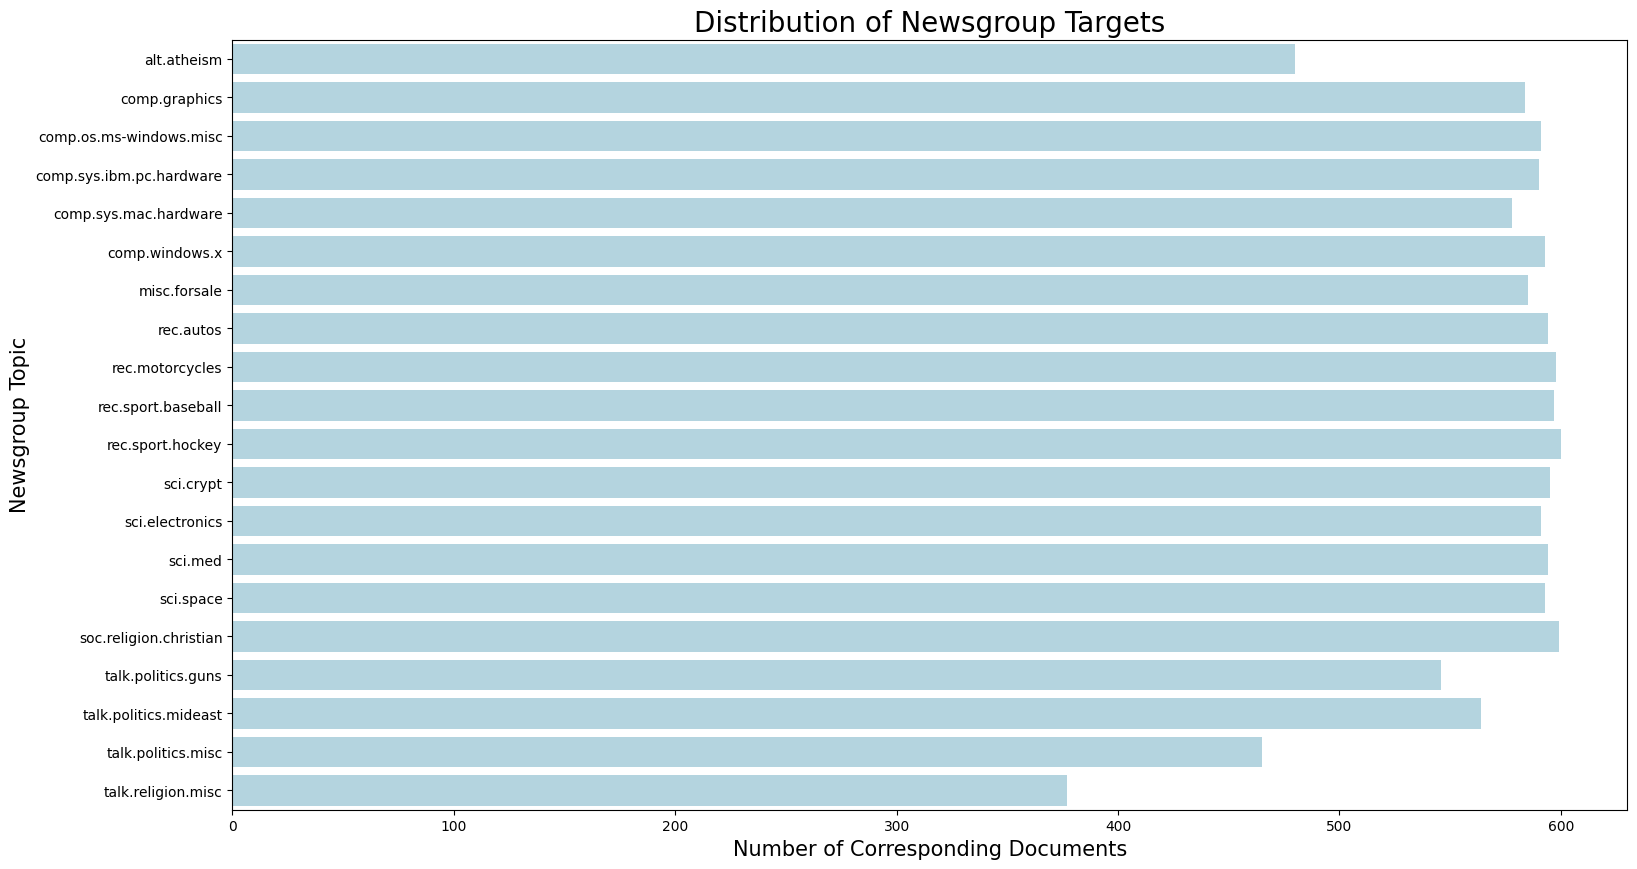

In [30]:
# plot the distribution of the newsgroups
fig1 = plt.figure(figsize =[18 ,10])
ax = sns.countplot(y=newsgroup_df['newsgroup'], color="lightblue", order=dataset.target_names)
plt.title('Distribution of Newsgroup Targets', size=20)
plt.ylabel('Newsgroup Topic', size = 15)
plt.xlabel('Number of Corresponding Documents', size = 15)

Talk.politics.misc and talk.religion.misc are more abstract, overlap with other topics like talk.politics.guns and alt.atheism, and have lower counts of associated documents. We will remove them from our training set and focus on the remaining 18 topics instead.

In [31]:
newsgroup_df = newsgroup_df[(newsgroup_df["newsgroup"] != 'talk.politics.misc') & (newsgroup_df["newsgroup"] != 'talk.religion.misc')]
newsgroup_df.shape

(10472, 3)

In [32]:
newsgroup_df["document"]

0        I was wondering if anyone out there could enli...
1        A fair number of brave souls who upgraded thei...
2        well folks, my mac plus finally gave up the gh...
3        Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> a...
4        From article <C5owCB.n3p@world.std.com>, by to...
                               ...                        
11309    DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...
11310    I have a (very old) Mac 512k and a Mac Plus, b...
11311    I just installed a DX2-66 CPU in a clone mothe...
11312    In article <1qkgbuINNs9n@shelley.u.washington....
11313    Stolen from Pasadena between 4:30 and 6:30 pm ...
Name: document, Length: 10472, dtype: object

In [33]:
words_per_document = newsgroup_df["document"].apply(lambda x: len(x.split(" ")))
mean_words = words_per_document.mean()
std_words = words_per_document.std()
print("mean number of words:", mean_words, "standard deviation of number of words:", std_words)

mean number of words: 257.52320473644005 standard deviation of number of words: 645.7135193230087


In [34]:
newsgroup_df["document"].apply(lambda x: len(x.split(" "))).value_counts().sort_values()[:300]

714      1
823      1
789      1
1138     1
3953     1
        ..
625      1
725      1
4869     1
10554    1
631      1
Name: document, Length: 300, dtype: int64

In [35]:
print('max words per document', max(words_per_document), ', min words per document', min(words_per_document))

max words per document 20083 , min words per document 1


{'whiskers': [<matplotlib.lines.Line2D at 0x7fec0dddfdf0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fec0ddd13d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fec0dddfb20>],
 'medians': [<matplotlib.lines.Line2D at 0x7fec0ddd1970>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fec0ddd1c40>],
 'means': []}

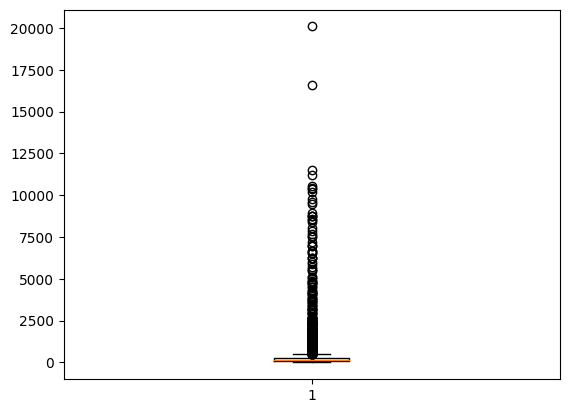

In [36]:
import matplotlib.pyplot
matplotlib.pyplot.boxplot(words_per_document)

In [91]:
#tokenize
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
from nltk.corpus import words
nltk.download('words')

# List of stop words
additional_stop_words = set(["article", "subject", 'time','im','thing', 'new', 'said', 'need', 'want', 'did',
                             'know','like','people','think','writes','just','dont', '___', 'good', 'used',
                            "use", "think", 'doe', "year", "say", "make", 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax'])
stop_words = ENGLISH_STOP_WORDS.union(additional_stop_words)

# Splits words on white spaces
def tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

def process_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation, numbers, \n, and extra whitespaces
    text = re.sub(r'\d+|[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = re.sub(r'\s{2,}', ' ', text)
    # only include english dictionary words
    # Tokenize and lemmatize
    wnl = WordNetLemmatizer()
    tokens = [wnl.lemmatize(word) for word in tokenizer(text) if word not in stop_words]
    text = [each for each in tokens if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return " ".join(text)

[nltk_data] Downloading package wordnet to /Users/sarah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/sarah/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [84]:
# Set options to display all rows and columns
newsgroup_df['document'][1]

"A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks."

In [85]:
newsgroup_df['document'][:10].apply(process_text)

0    wondering enlighten car saw day door sport car...
1    fair number brave soul upgraded si clock oscil...
2    folk mac plus finally gave ghost weekend start...
3    robert jc kyanko robrjckuucp wrote abraxisiast...
4    cowcbnpworldstdcom tombakerworldstdcom tom bak...
5    reuttransferstratuscom cdtswstratuscom tavares...
6    responded request info treatment astrocytomas ...
7    dxbpsuvmpsuedu qlbrlinnrkdnsnmsuedu bgrubbdant...
8    win downloaded icon bmps figure change wallpap...
9    jappocwruedu joseph pellettiere looking inform...
Name: document, dtype: object

In [92]:
### tokenize the abstracts
newsgroup_df['processed_documents'] = newsgroup_df['document'].apply(process_text)
newsgroup_df['processed_documents']

0        wondering enlighten car saw day door sport car...
1        fair number brave soul upgraded si clock oscil...
2        folk mac plus finally gave ghost weekend start...
3        robert jc kyanko robrjckuucp wrote abraxisiast...
4        cowcbnpworldstdcom tombakerworldstdcom tom bak...
                               ...                        
11309    dn nyedacnsvaxuwecedu david nye dn neurology d...
11310    old mac mac plus problem screen blank minor ph...
11311    installed dx cpu clone motherboard tried mount...
11312    qkgbuinnsnshelleyuwashingtonedu bolsoncarsonuw...
11313    stolen pasadena pm blue white honda cbrrr cali...
Name: processed_documents, Length: 10472, dtype: object

In [93]:
# Get the top 20 most common words among all the documents
from collections import Counter

p_text = ' '.join(newsgroup_df['processed_documents'].tolist())

p_text = p_text.split(' ')

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

top_20

,word,frequency
0,doe,3508
1,file,2821
2,right,2809
3,problem,2806
4,way,2586
5,work,2475
6,window,2402
7,god,2307
8,question,2042
9,program,1952


In [90]:
top_20['word'][15]

'said'

We can now preprocess the data for the topic model. We will first clean the documents by removing punctation, numbers, and characters, converting to lowercase, and stripping empty strings. We will also remove non-descriptive words such as "a", "is", "from", "and", etc. We will add additional stop words that occur often in our dataset but do not have any significant meaning for the theme extraction. Lastly, we will lemmatize our documents, meaning we will distill words into their foundational terms, like "running" to "run". This will help reduce unnecessary and redundant terms and ensure a faster runtime.

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)

# Fit and transform the processed abstracts into DTM
dtm = vectorizer.fit_transform(newsgroup_df['processed_documents'])

In [98]:
from sklearn.decomposition import NMF

# Specify the number of topics
n_topics = 18  # or any number based on your analysis needs
nmf_model = NMF(n_components=n_topics)
W = nmf_model.fit_transform(dtm)  # Document-topic matrix
H = nmf_model.components_         # Topic-term matrix

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [99]:
feature_names = vectorizer.get_feature_names_out()
for index, topic in enumerate(H):
    print(f"Topic #{index + 1}:")
    print(",".join([feature_names[i] for i in topic.argsort()[-10:]]))  # Top 10 words per topic

Topic #1:
thing,food,question,group,really,day,way,ive,msg,problem
Topic #2:
running,version,using,problem,font,manager,program,application,do,window
Topic #3:
hd,cable,switch,jumper,problem,boot,hard,floppy,disk,drive
Topic #4:
fan,league,baseball,hockey,season,win,play,player,team,game
Topic #5:
secure,algorithm,bit,phone,government,escrow,clipper,encryption,chip,key
Topic #6:
church,truth,belief,atheist,believe,faith,bible,jesus,christian,god
Topic #7:
manual,sell,asking,modem,printer,condition,shipping,price,sale,offer
Topic #8:
bus,vesa,vga,graphic,mode,ati,diamond,video,driver,card
Topic #9:
help,information,address,doe,info,looking,hi,advance,email,thanks
Topic #10:
policy,state,lebanon,peace,lebanese,palestinian,jew,arab,israeli,israel
Topic #11:
convert,gif,disk,bmp,ftp,image,directory,format,program,file
Topic #12:
government,handgun,state,crime,criminal,right,firearm,law,weapon,gun
Topic #13:
azerbaijan,azeri,muslim,greek,genocide,turk,turkey,armenia,turkish,armenian
Topic #

In [104]:
import numpy as np

# Let's say we want the topic distribution for the first document (index 0)
document_index = 10
document_topics = W[document_index]  # Get topic weights for this document

# Identify the dominant topic for this document
dominant_topic = np.argmax(document_topics)

print(f"Document #{document_index + 1} dominant topic: Topic {dominant_topic + 1}")
print(f"Topic Distribution for Document #{document_index + 1}:")
for topic_idx, weight in enumerate(document_topics):
    print(f"Topic {topic_idx + 1}: {weight:.4f}")

# Print the top words for the dominant topic to understand its meaning
top_word_indices = H[dominant_topic].argsort()[-10:]  # Top 10 words for the dominant topic
print(f"\nTop words for Dominant Topic {dominant_topic + 1}:")
print(" ".join([feature_names[i] for i in top_word_indices]))
print(newsgroup_df.iloc[document_index]["newsgroup"])
print(newsgroup_df.iloc[document_index]["document"])

Document #11 dominant topic: Topic 17
Topic Distribution for Document #11:
Topic 1: 0.0000
Topic 2: 0.0000
Topic 3: 0.0023
Topic 4: 0.0000
Topic 5: 0.0000
Topic 6: 0.0000
Topic 7: 0.0025
Topic 8: 0.0000
Topic 9: 0.0245
Topic 10: 0.0000
Topic 11: 0.0000
Topic 12: 0.0000
Topic 13: 0.0000
Topic 14: 0.0004
Topic 15: 0.0111
Topic 16: 0.0000
Topic 17: 0.1161
Topic 18: 0.0091

Top words for Dominant Topic 17:
mile honda dod helmet dog riding rider ride motorcycle bike
rec.motorcycles
I have a line on a Ducati 900GTS 1978 model with 17k on the clock.  Runs
very well, paint is the bronze/brown/orange faded out, leaks a bit of oil
and pops out of 1st with hard accel.  The shop will fix trans and oil 
leak.  They sold the bike to the 1 and only owner.  They want $3495, and
I am thinking more like $3K.  Any opinions out there?  Please email me.
Thanks.  It would be a nice stable mate to the Beemer.  Then I'll get
a jap bike and call myself Axis Motors!

-- 
----------------------------------------

### Run NMF